In [32]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

Etant donné que nous sommes exceptionnellement un groupe constitué de trois personnes, nous vous proposons le sujet 1 enrichi avec le sujet 3. Concrètement, nous allons implémenter 4 méthodes d'optimisations, puis les comparer sur la base de données ... (à choisir) :
- Batch Proximal Gradient Descent (avec accéleration Nesterov, aka FISTA)
- SDCA (avec eventuellement quelques optimisations présentées dans l'article)
- SVRG
- SAGA

# Projet optimisation : algorithme SDCA

On va se concentrer sur l'algorithme SVM avec régularisation LASSO. 

Commençons par les notations afin de fixer les idées :
- les données seront noté par la matrice $X$ de taille (n_samples, n_features)
- le paramètre à estimer est $\theta$ de taille n_features
- les valeurs à prédire sont dans le vecteur $b$ de taille n_samples

Afin de pouvoir fixer de manière optimale les pas de descentes, nous allons utiliser une version smooth de la hinge loss : la square hinge loss (smoothness $\gamma = \| X \|_2 ^ 2$), mais qui n'est pas strongly convex (à vérifier...). On s'attend donc à avoir une convergence en $\frac{\gamma}{t} $.

$$ l(b,X^T \theta) = \frac{1}{n\_samples} \sum_{i=1}^{n\_samples} max(0, 1 - b_i X_i^T \theta)^2 $$

Le gradient s'écrit

$$ \nabla_\theta l(b, X^T \theta) = \frac{1}{n\_samples}  \sum_{i=1}^{n\_samples} \left\{
    \begin{array}{ll}
        0 & \mbox{si } b_i X_i^T \theta > 1 \\
        -2 b_i X_i^T (1 - b_i X_i^T \theta) & \mbox{sinon.}
    \end{array}
\right. $$

Enfin, la perte considéré étant le LASSO, ie la régularisation l1, le fontion $\psi$ considérée s'écrit ici :
$$ \psi (\theta) = |\theta|_1 $$ 

Le prox se calcule donc de cette manière :

$$ \theta_{t+1} = \theta_t - \eta \nabla_\theta l(b, X^T \theta_t) - \eta \lambda \text{sgn}(\theta_t) $$
(en principe c'est sgn($\theta$) mais on va approximer...)

*[Partie 1 : Batch Proximal Gradient Descent](#section1)

*[Partie 2 : Coordinate descent (primal) and SDCA](#section2)

*[Partie 3 : SVRG](#section3)

*[Partie 4 : SAGA](#section4)

*[Partie 5 : Comparaison](#section1)

# Définition des données

On commence par définir les données de test (il faudra plus tard mettre les vraies données)

In [89]:
np.random.seed(0)

def binarize(x):
    return np.sign(x)

n_samples, n_features = 2500, 2
X = np.random.randn(n_samples, n_features)
w = np.random.randn(n_features)
b = binarize(X.dot(w) + 0.1 * np.random.randn(n_samples))

On définit aussi les fonctions de couts et gradient (pour la hinge et la squared hinge)

In [92]:
# On commence avec la hinge normale
def f_hinge(theta, lam):
    cost = 1-np.multiply(b,X.dot(theta))
    cost[cost <= 0] = 0
    return np.mean(cost) + lam * np.linalg.norm(theta, ord=1)

def partial_grad_hinge(theta, i):
    if b[i] * X[i].dot(theta) < 1:
        return -b[i] * X[i]
    return 0 * X[i] 

def grad_hinge(theta):
    gradient = -np.multiply(b, X.T)
    gradient[:,np.multiply(b, X.dot(theta)) >= 1] = 0 * gradient[:,np.multiply(b, X.dot(theta)) >= 1]
    return np.mean(gradient, axis=1)


# On continue avec la squared hinge
def f(theta, lam):
    cost = (1-np.multiply(b,X.dot(theta))) ** 2
    cost[cost <= 0] = 0
    return np.mean(cost) + lam * np.linalg.norm(theta, ord=1)

def partial_grad(theta, i):
    if b[i] * X[i].dot(theta) < 1:
        return -2 * b[i] * X[i]* (1 - b[i] * X[i].dot(theta))
    return 0 * X[i] 

def grad(theta):
    gradient = np.multiply( np.multiply(-2*b, X.T) , (1 - np.multiply(b, X.dot(theta))) )
    gradient[:,np.multiply(b, X.dot(theta)) >= 1] = 0 * gradient[:,np.multiply(b, X.dot(theta)) >= 1]   
    return np.mean(gradient, axis=1)

et les différentes constantes :
- pénalisation : lambda = 0.1
- pas de descente : eta = $\frac{1}{\|X\|_2^2}$  ($\frac{1}{\gamma}$, avec $\gamma=\|X\|_2^2$)
- nombre d'itération : T = 7000

In [108]:
lam = 0.1
eta = 1./(np.linalg.norm(X) ** 2)
T = 7000

<a id='section1'></a>
Batch Proximal Gradient Descent

In [109]:
def PGD(T, lam, eta):
    # pas de la descente
    # Lipschitz constant
    #L = np.linalg.norm(X.T.dot(X))
    #eta = 1. / L
    
    
    # initialisation
    theta = np.zeros(n_features)
    
    # historique de la fonction de perte
    cost_history = np.empty(shape=[T])
    
    for t in range(0,T):
        cost_history[t] = f(theta, lam)
        
        # compute gradient
        gt = grad(theta)
        
        # compute prox
        theta = theta - eta * gt - eta * lam * np.sign(theta)
        
        
               
    return theta, cost_history

In [110]:
%timeit PGD(T=T,lam=lam,eta=eta)

1 loop, best of 3: 2.7 s per loop


In [111]:
theta, cost_history_PGD = PGD(T=T,lam=lam,eta=eta)

In [112]:
print(theta)
print(w)

[ 0.2690804  -0.72712218]
[ 0.30972382 -0.73745619]


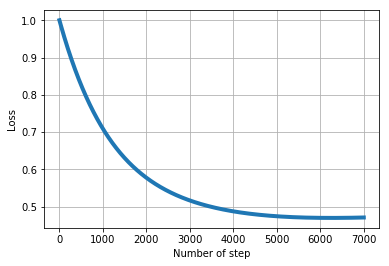

In [113]:
plt.plot(cost_history_PGD, lw=4)
plt.grid()
#plt.yscale('log')
plt.ylabel('Loss')
plt.xlabel('Number of step')
plt.show()

On passe à l'accélération Nesterov

In [114]:
def FISTA(T, lam, eta):
    # pas de la descente
    # Lipschitz constant
    #L = np.linalg.norm(X.T.dot(X))
    #eta = 1. / L
    #eta = 0.1
    st_moins2 = 1.
    st_moins1 = 1.
    st = 1.
    
    # initialisation
    theta_moins1 = np.zeros(n_features)
    theta = np.zeros(n_features)
    theta_nesterov = np.zeros(n_features)
    
    # historique de la fonction de perte
    cost_history = np.empty(shape=[T])
    
    for t in range(0,T):
        cost_history[t] = f(theta, lam)
        
        # compute gradient
        gt = grad(theta_nesterov)
        
        # compute st
        st_moins2 = st_moins1
        st_moins1 = st
        st = (1 + np.sqrt(1 + 4 * st**2)) / 2 
        
        # compute prox
        theta_moins1 = theta
        theta = theta_nesterov - eta * gt - eta * lam * np.sign(theta_nesterov)
        
        # compute nestorov acceleration
        theta_nesterov = theta + (st_moins2 / st_moins1) * (theta - theta_moins1)
        
        
               
    return theta_nesterov, cost_history

In [42]:
%timeit FISTA(T=T,lam=lam,eta=eta)

10 loops, best of 3: 29.3 ms per loop


In [115]:
theta, cost_history_FISTA = FISTA(T=T,lam=lam,eta=eta)

In [116]:
print(theta)
print(w)

[ 0.43520334 -1.17384972]
[ 0.30972382 -0.73745619]


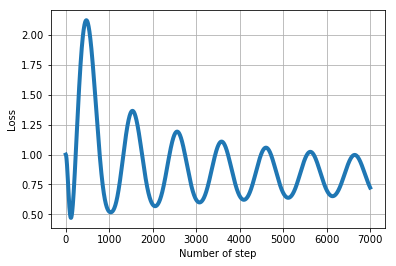

In [117]:
plt.plot(cost_history_FISTA, lw=4)
plt.grid()
#plt.yscale('log')
plt.ylabel('Loss')
plt.xlabel('Number of step')
plt.show()

<a id='section2'></a>
SDCA

Nous allons commencer avec l'algorithme de coordinate descent dans le cadre primal avant de passer au problème dual (ie. l'algo SDCA)

def CD(T, lam, eta):
    
    # initialisation
    theta = np.zeros(n_features)
    
    # historique de la fonction de perte
    cost_history = np.empty(shape=[T])
    
    for t in range(0,T):
        cost_history[t] = f(theta, lam)
        
        # .. pick random coordinate ..
        idx = np.random.randint(0, n_features)
        
        # compute partial gradient
        gj = 
        gt = grad(theta_nesterov)
        
        # compute st
        st_moins2 = st_moins1
        st_moins1 = st
        st = (1 + np.sqrt(1 + 4 * st**2)) / 2 
        
        # compute prox
        theta_moins1 = theta
        theta = theta_nesterov - eta * gt - eta * lam * np.sign(theta_nesterov)
        
        # compute nestorov acceleration
        theta_nesterov = theta + (st_moins2 / st_moins1) * (theta - theta_moins1)
        
        
               
    return theta_nesterov, cost_history

Nous allons d'abord implémenter la version la plus classique de l'algorithme, avant de mettre en oeuvre les variantes et améliorations proposées dans http://www.jmlr.org/papers/volume14/shalev-shwartz13a/shalev-shwartz13a.pdf

On définit les fonctions de coût (primal et dual) qui permettront de monitorer l'avancée de l'algorithme. (Remarque : la fonction P est identique que la fonction f définie plus haut, mais on décide de la redéfinir ici pour coller aux notations de l'article)

In [118]:
#step_size = 1.0 / (3 * np.max((X * X).sum(1)))      #ici on travaille toujours avec un step_size constant


def P(theta, lam):
    cost = 1-np.multiply(b,X.dot(theta))
    cost[cost <= 0] = 0
    return np.mean(cost) + lam * np.linalg.norm(theta, ord=1)

def D(alpha, lam):
    cost = np.multiply(b,X.dot(theta))
    cost[cost > 0] = np.nan
    cost[cost < -1] = np.nan
    return cost                    

### SDCA classique

In [119]:
def SDCA(T, lam, eta):
    alpha = np.zeros(n_samples)
    w = (1/(lam*n_samples))*np.dot(X.T,alpha)
    
    grad_history = np.empty(shape=[T])
    cost_history = np.empty(shape=[T])
    
    for t in range(0,T):
        cost_history[t] = P(w, lam)
        
        # .. pick random sample ..
        idx = np.random.randint(0, n_samples)
        
        # on calcule les constantes A et B (utiles pour la résolution du delta alpha i)
        A = (1/(lam*n_samples)) * np.linalg.norm(X[idx])**2
        B = X[idx].T.dot(w)    
        
        y_i = b[idx]
        delta_alpha_i_tilde = (y_i-B)/A        
        delta_alpha_i = y_i * np.clip(y_i*(delta_alpha_i_tilde + alpha[idx]), a_min=0, a_max=1) - alpha[idx]
        
        alpha[idx] = alpha[idx] + delta_alpha_i
    
        w = (1/(lam*n_samples))*np.dot(X.T,alpha)
        

        
        
    return w, cost_history
        

In [120]:
%timeit SDCA(T=T,lam=lam,eta=eta)

1 loop, best of 3: 880 ms per loop


In [121]:
theta, cost_history_SDCA = SDCA(T=T,lam=lam,eta=eta)

In [122]:
print(theta)
print(w)

[ 0.59416073 -1.38290389]
[ 0.30972382 -0.73745619]


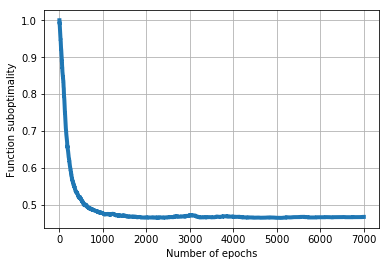

In [123]:
plt.plot(cost_history_SDCA, lw=4)
plt.grid()
#plt.yscale('log')
plt.ylabel('Function suboptimality')
plt.xlabel('Number of epochs')
plt.show()

## SCDA avec SGD initilisation

...

<a id='section3'></a>
SVRG

In [124]:
def SVRG(T, m, lam, eta):
    # initialisation
    theta_hat = np.zeros(n_features)
    
    # historique de la fonction de perte
    cost_history = np.empty(shape=[T*m])
    
    for t in range(0,T): 
        cost_history[t] = f(theta_hat, lam)
        
        # vrai gradient
        g_hat = grad(theta_hat)
    
        theta = np.zeros([m+1, n_features])
        theta[0,:] = theta_hat
        for k in range(0,m):
            # random sample an indice
            idx = np.random.randint(0, n_samples) 

            # compute variance reduced gradient
            g = partial_grad(theta[k], idx) - partial_grad(theta_hat, idx) + g_hat

            # compute prox
            theta[k+1] = theta[k] - eta * g - eta * lam * np.sign(theta[k])
        
        # on retire la première ligne
        theta = theta[1:]
        
        theta_hat = np.mean(theta, axis=0)
        
        
               
    return theta_hat, cost_history

In [125]:
%timeit SVRG(T=T,m=10,lam=lam,eta=eta)

1 loop, best of 3: 5.03 s per loop


In [126]:
theta, cost_history_SVRG = SVRG(T=T, m=10, lam=lam, eta=eta)

In [127]:
print(theta)
print(w)

[ 0.42234099 -1.14189537]
[ 0.30972382 -0.73745619]


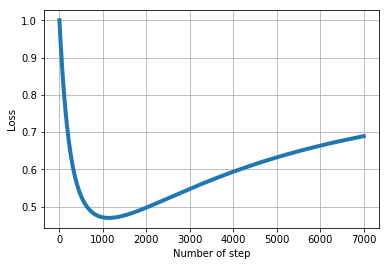

In [128]:
plt.plot(cost_history_SVRG, lw=4)
plt.grid()
#plt.yscale('log')
plt.ylabel('Loss')
plt.xlabel('Number of step')
plt.show()

<a id='section4'></a>
SAGA

In [129]:
def SAGA(T, lam, eta):
    # initialisation
    theta = np.zeros(n_features)
    
    gi_hat = np.zeros([n_samples, n_features])
    g_bar = np.zeros(n_features)
    
    # historique de la fonction de perte
    cost_history = np.empty(shape=[T])
    
    for t in range(0,T): 
        cost_history[t] = f(theta, lam)
        
        # random sample an indice
        idx = np.random.randint(0, n_samples) 
        
        gi = partial_grad(theta, idx)
        
        # estimate gradient
        g_hat = gi - gi_hat[idx] + g_bar
        
        # update average gradient
        g_bar = g_bar + (1./n_samples) * (gi - gi_hat[idx])
        
        # update stored gradient
        gi_hat[idx] = gi
        
        # compute prox
        theta = theta - eta * g_hat - eta * lam * np.sign(theta)
            
               
    return theta, cost_history

In [130]:
%timeit SAGA(T=T,lam=lam,eta=eta)

1 loop, best of 3: 585 ms per loop


In [131]:
theta, cost_history_SAGA = SAGA(T=T, lam=lam, eta=eta)

In [132]:
print(theta)
print(w)

[ 0.26968794 -0.72551797]
[ 0.30972382 -0.73745619]


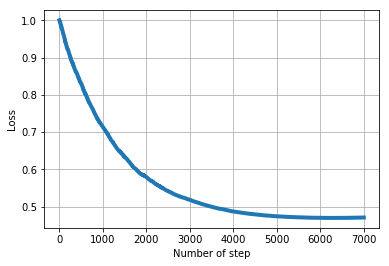

In [133]:
plt.plot(cost_history_SAGA, lw=4)
plt.grid()
#plt.yscale('log')
plt.ylabel('Loss')
plt.xlabel('Number of step')
plt.show()

<a id='section5'></a>
Comparaison des algorithmes

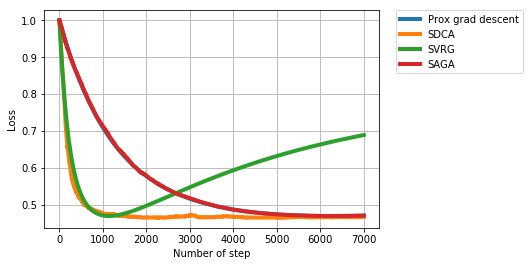

In [134]:
plt.plot(cost_history_PGD, lw=4, label='Prox grad descent')
#plt.plot(cost_history_FISTA, lw=4, label='FISTA')
plt.plot(cost_history_SDCA, lw=4, label='SDCA')
plt.plot(cost_history_SVRG, lw=4, label='SVRG')
plt.plot(cost_history_SAGA, lw=4, label='SAGA')
plt.grid()
#plt.yscale('log')
plt.ylabel('Loss')
plt.xlabel('Number of step')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()